In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *
from src.agents.supervisor_trader import SupervisorTrader
from src.agents.marginal_agent import MarginalAgent
from src.agents.supervisor_margin_trader import SupervisorMarginTrader
from src.news_providers.tradingview_provider import TradingViewProvider

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
coin = "ETH"

cutoff = get_current_datetime()
str(cutoff)

'2024-05-10 18:01:54.094817'

In [7]:
day_12h_history, day_history, week_history = map_async(lambda: get_12h_history(coin), lambda: get_day_history(coin), lambda: get_week_history(coin))

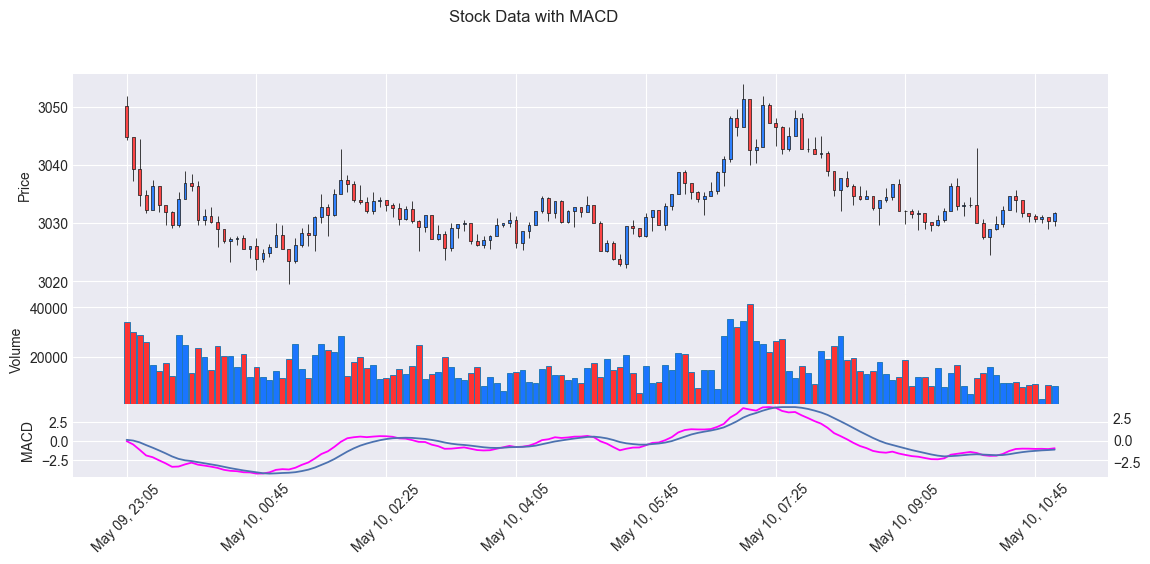

In [10]:
make_candlebars(day_12h_history)

In [12]:
napi = TradingViewProvider()
trading_agent = SupervisorMarginTrader()
filtering_agent = NewsFilteringAgent()

In [13]:
news = napi.get_news(coin)
filtered_news = filtering_agent.filter_news(coin, news[:30])
json.loads(filtered_news)

{'description': 'Ethereum (ETH) is holding steady above the $3,000 mark, despite facing critical support in this region. Recent news indicates that Ethereum Foundation transferred 1,000 ETH, raising market timing concerns yet again. Historically, such moves by the Foundation have coincided with market tops, creating anxiety about potential upcoming declines in price. However, technical analyses suggest there is a possibility for a bullish momentum if ETH breaks the $3,080 resistance level. Investors are monitoring these developments closely, alongside any regulatory news that might impact the cryptocurrency space.',
 'sentiment': 'Cautiously optimistic',
 'sentiment_description': "The general sentiment in the ETH market is cautiously optimistic due to solid support at the $3,000 level and potential for upward movement if resistance at $3,080 is broken. However, there remains underlying concern related to the Ethereum Foundation's recent cryptocurrency transfer, sparking fears of a poss

In [21]:
balance = {coin: 0, "USDT": 1000}
operations_history = []

[{'role': 'system', 'content': "You are professional momentum trader with an extensive understanding of cryptocurrency markets. \n                \n                Respond with JSON of described format.\n                Guidelines:\n                - Do not buy on everything you have, distribute spendings!\n                - Feel free to sell all if selling improves total net_worth of acccount\n                - Consider historical market data and recent news.\n                - Use only money from your 'balance'\n                \n                Your ultimate goal is to make make as much profit as possible\n                "}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the 12 hours. Current price: 3031.81'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the last day.'}, {'type': 'image_url', 'image_url': {'url': '', 'det
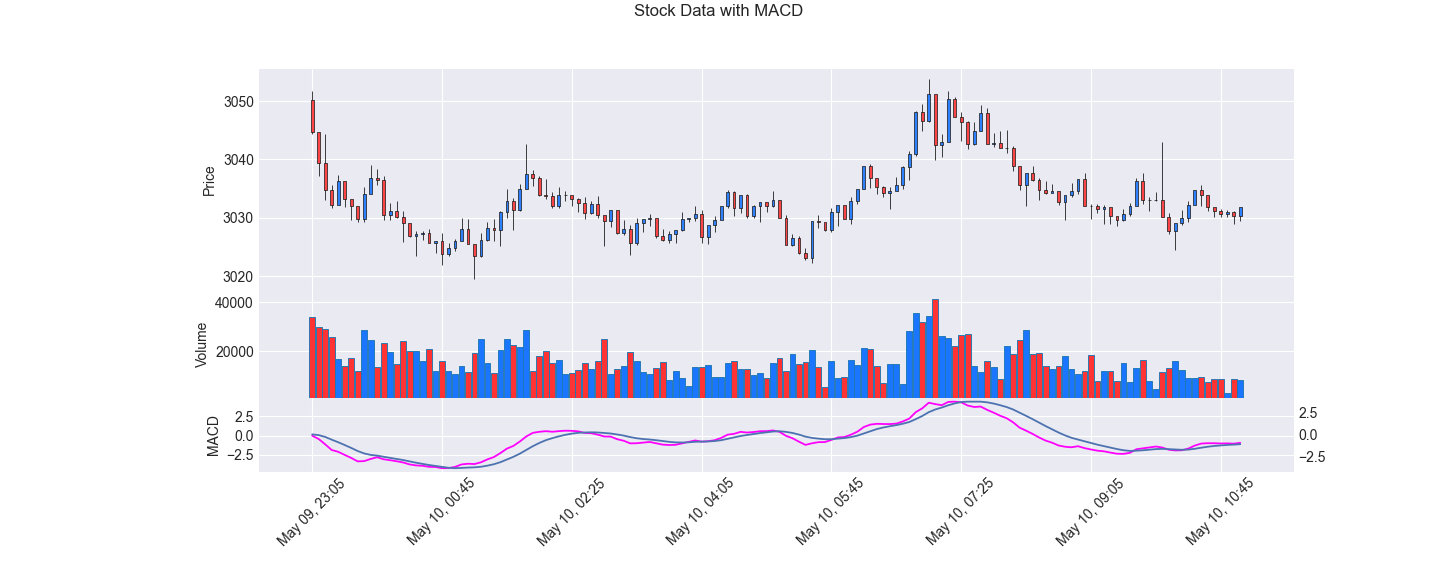
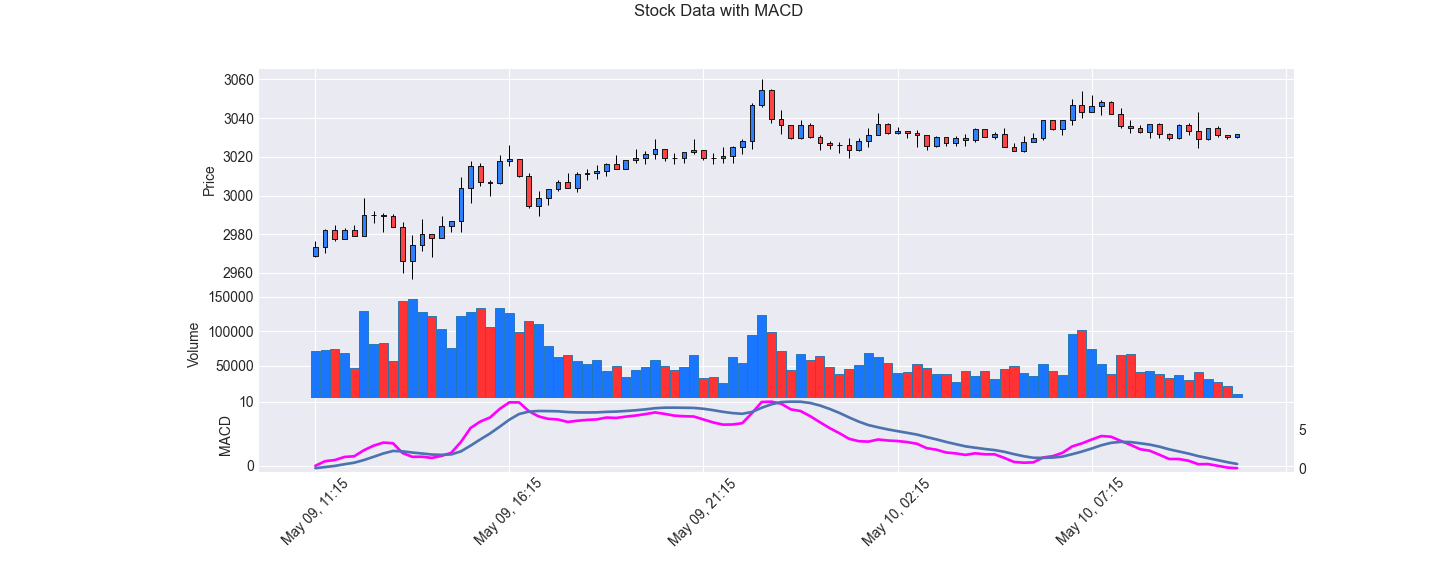
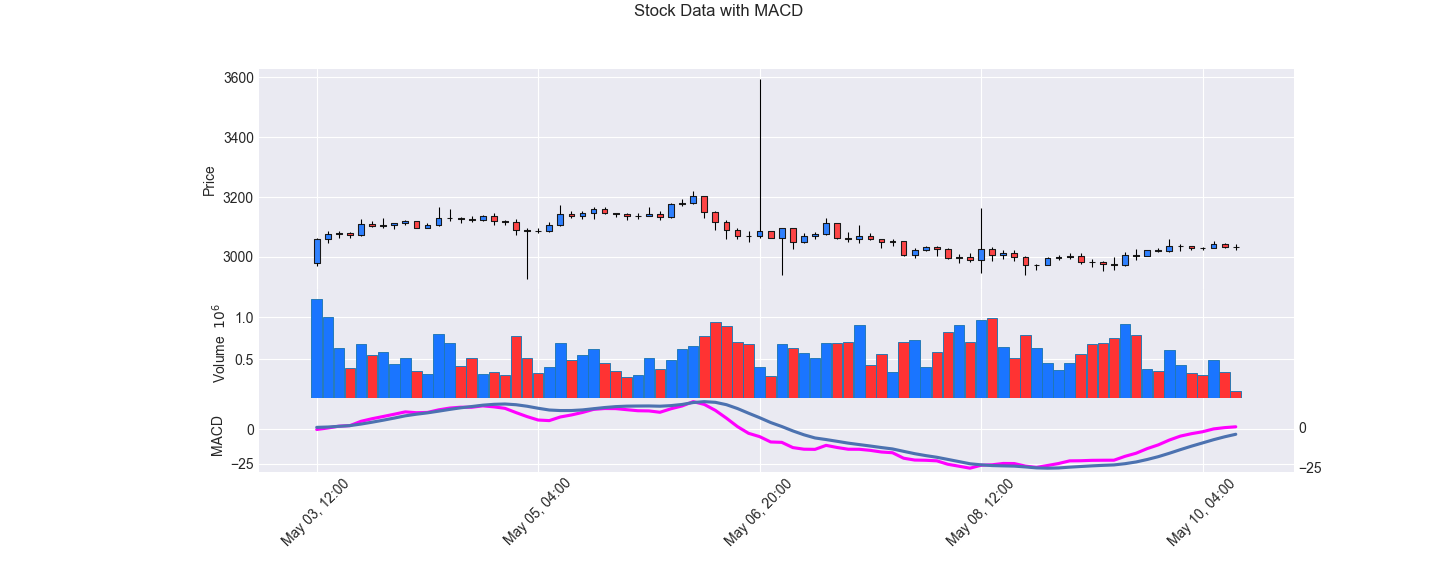

{'strategy_evaluation': 'The strategy to go long on Ethereum at $3031.81 is underpinned by the current market stability above $3,000 and technical indicators hinting at a bullish trend reversal. However, vulnerabilities remain due to possible larger macroeconomic factors which could influence cryptocurrency markets, such as regulatory news or shifts in the broader financial markets.',
 'calculations_evaluation': 'The calculations for potential profits and stop-loss triggers are accurate based on the set parameters. Assuming Ethereum hits the take-profit price of $3,150 from an entry point of $3031.81, the gain calculation of approximately 3.9% is correct. The stop-loss at approximately -2.4% if the price reaches $2,960 is also accurately calculated.',
 'changes_description': 'No changes are necessary to the strategy as the assessments for market conditions, potential profit margins, and risk management align well with current market trends and technical analysis. The plan is confirmed 

In [26]:
predict, _ = trading_agent.decide(
    coin=coin,
    news=filtered_news,
    day_12h_data=day_12h_history,
    day_data=day_history,
    week_data=week_history,
    #year_data=year_history,
    operations_history=operations_history,
    current_balance=balance,
    leverage="1x",
    verbose=True,
)

result = json.loads(predict)
result